In [9]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import languagemodel
import embedding
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [18]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODELS = [
    languagemodel.Bart(DEVICE, 'bart-large', 32),
    languagemodel.BERT(DEVICE, 'bert-large-cased', 16),
    languagemodel.BERT(DEVICE, 'distilbert-base-cased', 32),
    languagemodel.XLNet(DEVICE, 'xlnet-base-cased', 32),
    languagemodel.XLM(DEVICE, 'xlm-mlm-en-2048', 32),
#     languagemodel.GPT2(DEVICE, 'gpt2', 32),
#     embedding.Word2Vec(DEVICE, 'w2v', '../gensim_w2v.txt') # load w2v embeddings computed with gensim
]

Language model 'bart-large'initialized (batchsize = 32) on cuda.
Language model 'bert-large-cased'initialized (batchsize = 16) on cuda.
Language model 'distilbert-base-cased'initialized (batchsize = 32) on cuda.
Language model 'xlnet-base-cased'initialized (batchsize = 32) on cuda.
Language model 'xlm-mlm-en-2048'initialized (batchsize = 32) on cuda.


In [19]:
def get_pmis(model, sentences, n_sentences='all', verbose=False):
    '''get estimates get scores for n (default all) sentences'''

    savez_dict = dict()

    if n_sentences == 'all':
        n_sentences = len(sentences)

    for i, sentence in enumerate(tqdm(sentences[:n_sentences], desc=model.model_spec)):
        pmi_dict = dict()
        # get a pmi matrix and a pseudo-logprob for the sentence
        pmi_matrix, pseudo_loglik = model.ptb_tokenlist_to_pmi_matrix(
            sentence, add_special_tokens=True, verbose=verbose,
            pad_left=None, pad_right=None)
        if verbose:
            tqdm.write(f"pmi for sentence {i}\n{sentence}")
            tqdm.write(f"pseudo_loglik: {pseudo_loglik}")
            tqdm.write(f"{pmi_matrix}")
        pmi_dict['sentence'] = sentence
        pmi_dict['pmi_matrix'] = pmi_matrix
        pmi_dict['pseudo_loglik'] = pseudo_loglik

        savez_dict[str(i)] = pmi_dict
    return savez_dict

In [20]:
sentences=[
    "It is impossible to know whether that theory is realistic .", #442
    "The utility company currently has about 82.1 million shares outstanding .", # 1466
    "By 9:45 , the industrial average had dropped 27 points .", # 1535
    "Each of the four earthly elements has its natural place .",
    "By soul he simply meant the form of a living being .",
    "Increasingly , women are contributing more to household income than men .",
    "Multiplying all observations by a constant does not alter significance .",
    "The bigger one is farther away . It just looks smaller .",
    "The bigger ones are farther away . It just looks smaller .",
    "The bigger one was farther away . It just looks smaller .",
    "The bigger ones slid farther away . It just looks smaller .",
    "To process this document will take a long time .",
    "This document will take a long time to process ."
]
sentences = [line.strip().split(' ')
                     for line in sentences]
pmis_dicts = []
for _, model in enumerate(MODELS):
    pmis_dicts.append(get_pmis(model, sentences))

It is impossible to know whether that theory is realistic .


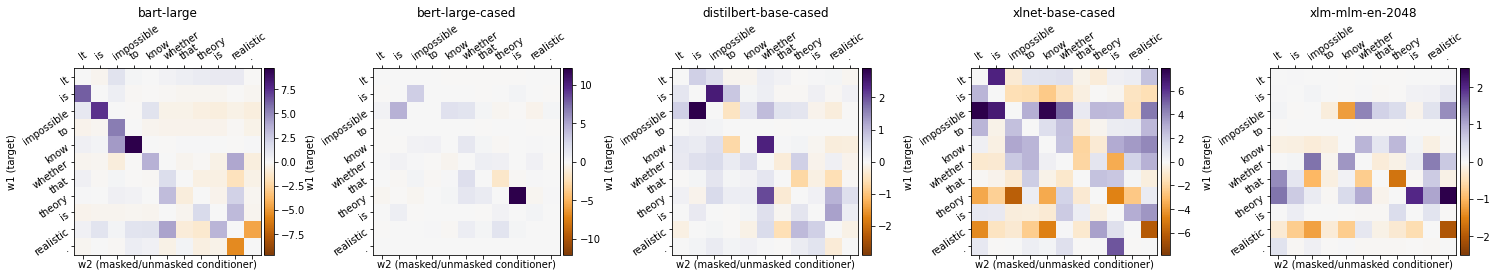

The utility company currently has about 82.1 million shares outstanding .


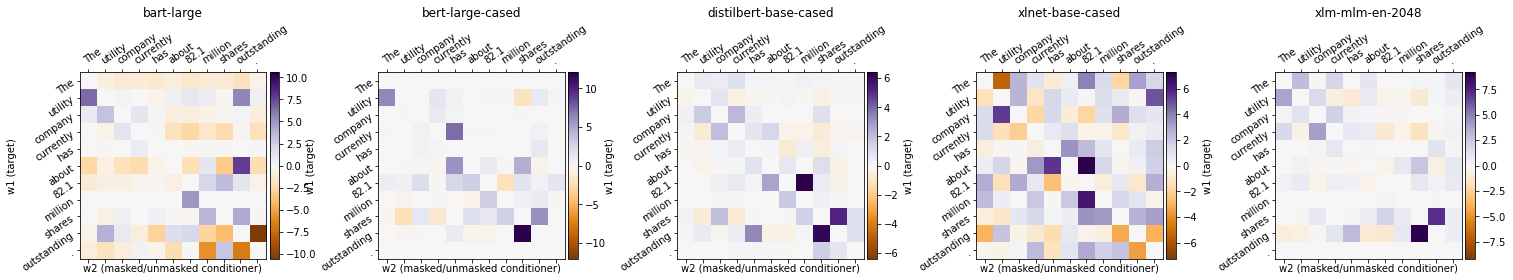

By 9:45 , the industrial average had dropped 27 points .


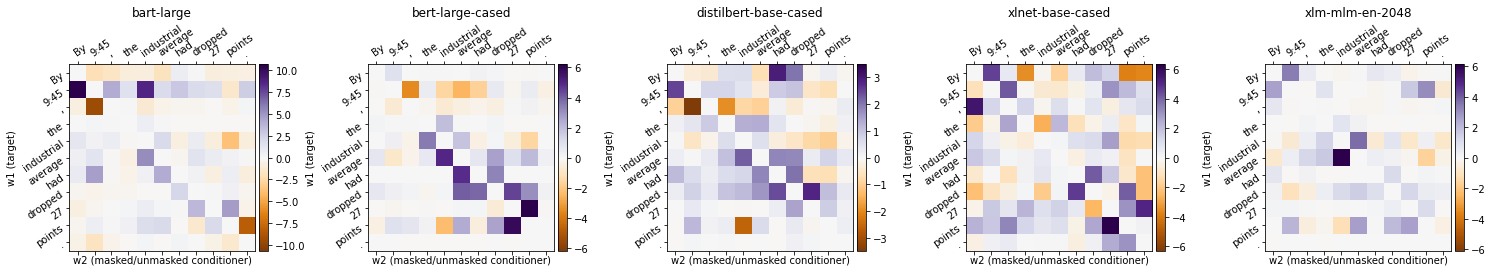

Each of the four earthly elements has its natural place .


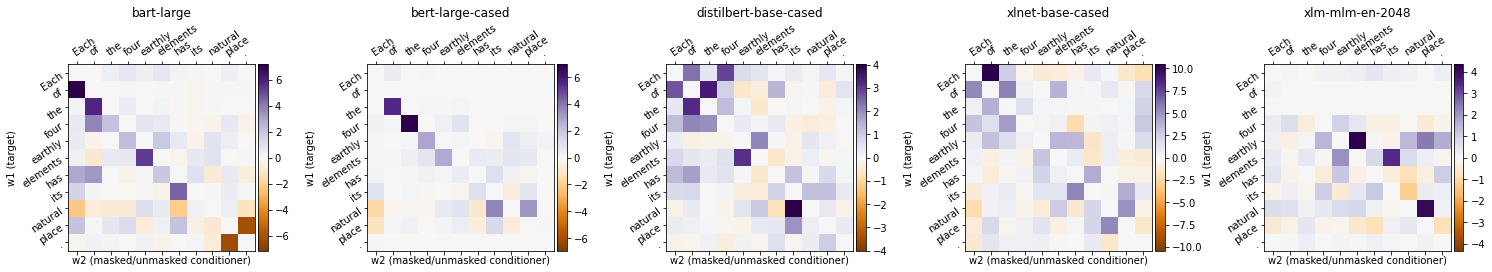

By soul he simply meant the form of a living being .


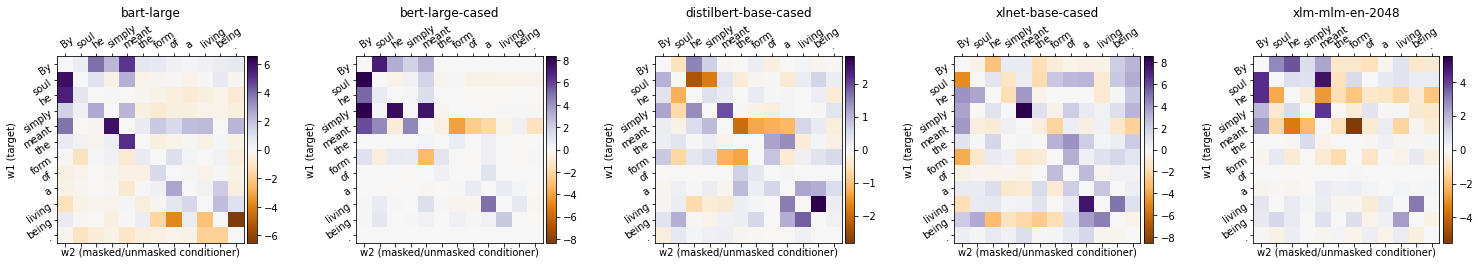

Increasingly , women are contributing more to household income than men .


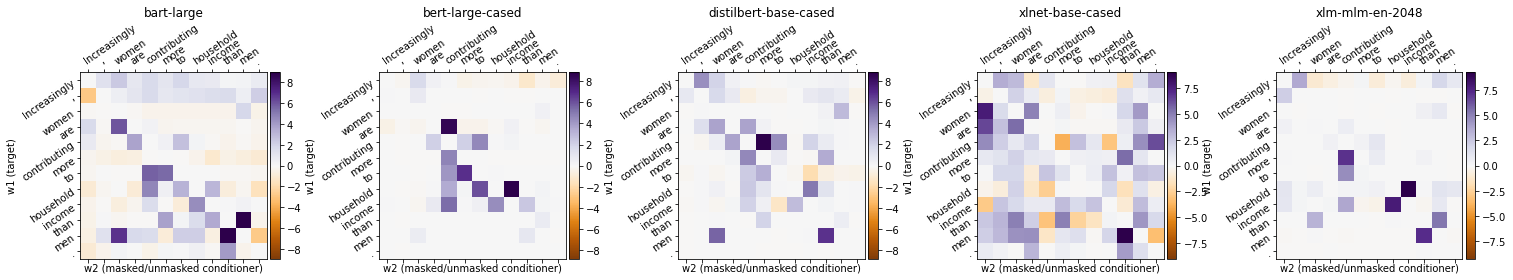

Multiplying all observations by a constant does not alter significance .


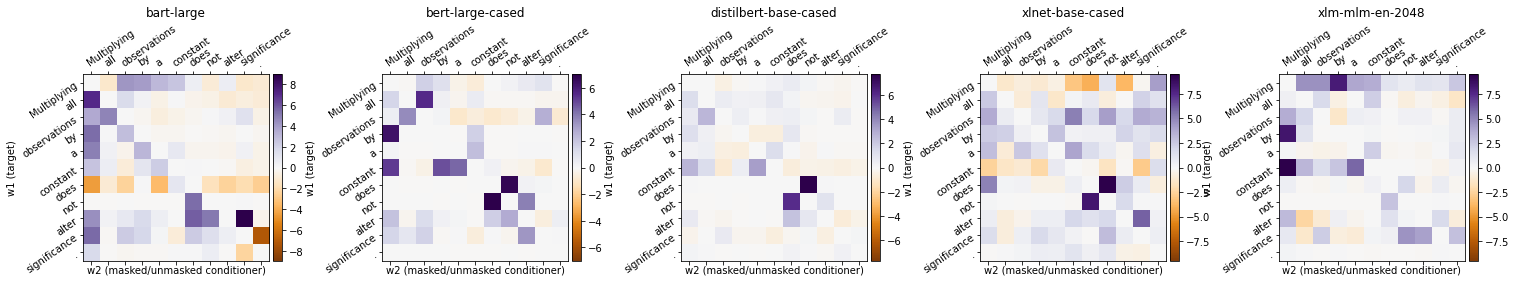

The bigger one is farther away . It just looks smaller .


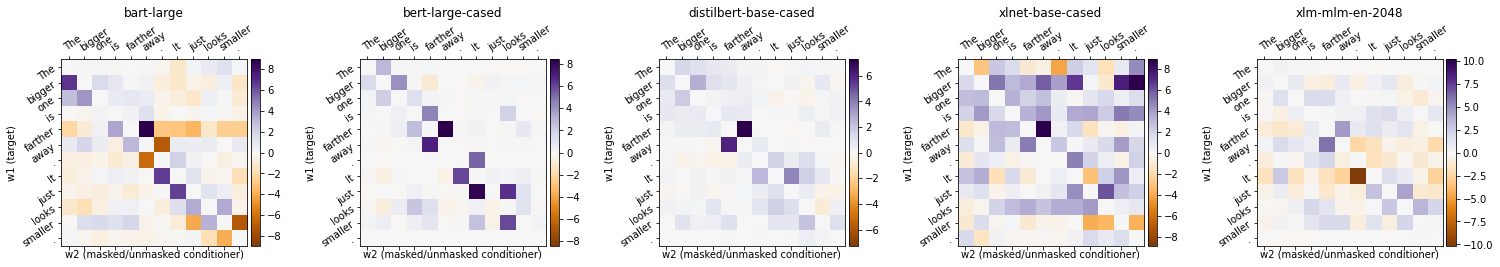

The bigger ones are farther away . It just looks smaller .


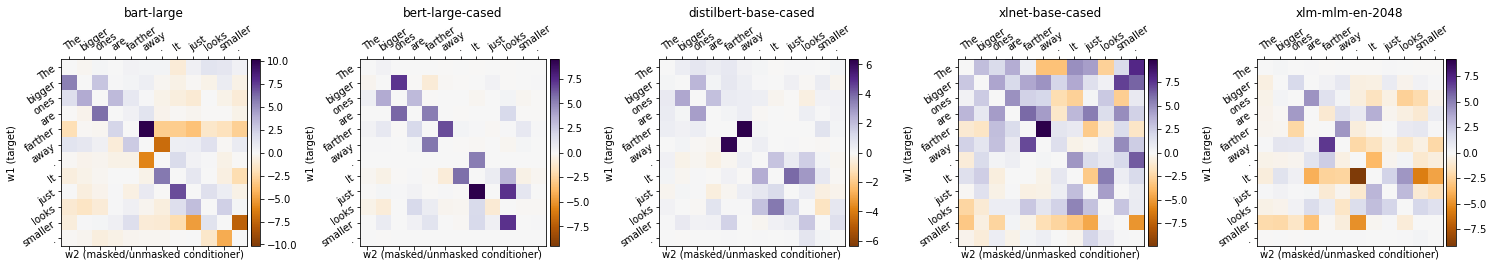

The bigger one was farther away . It just looks smaller .


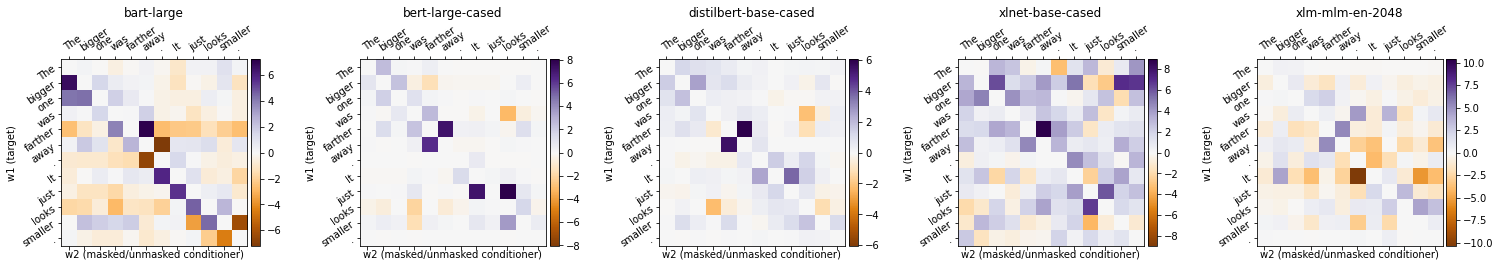

The bigger ones slid farther away . It just looks smaller .


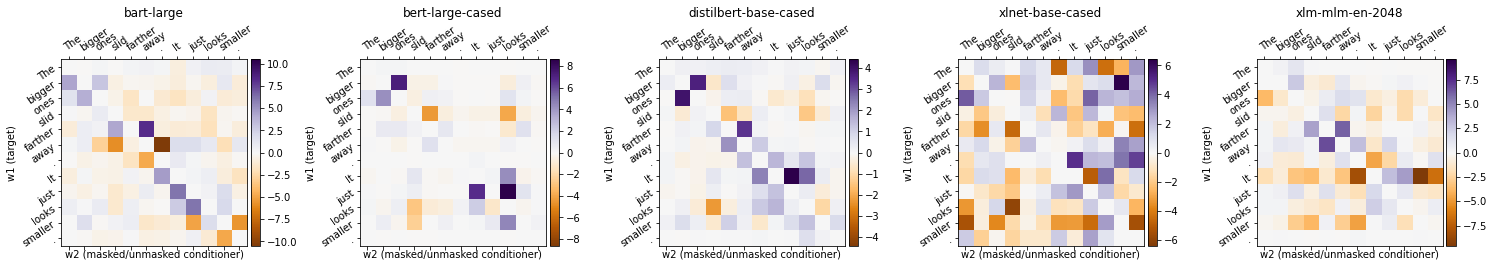

To process this document will take a long time .


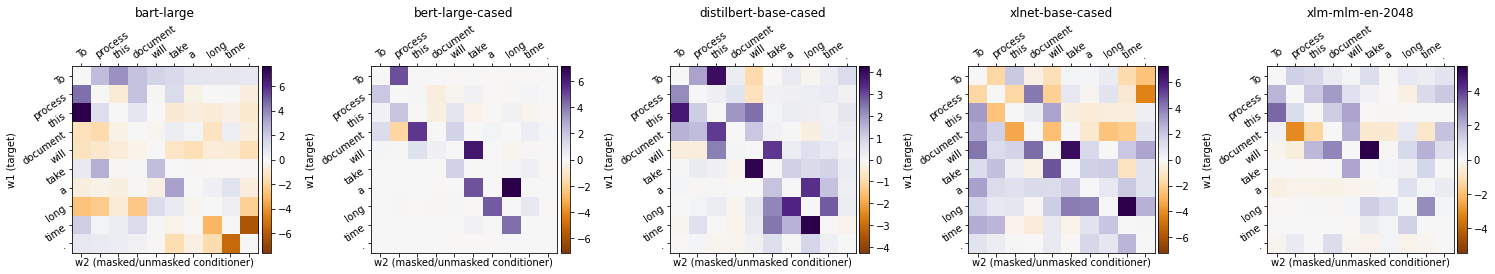

This document will take a long time to process .


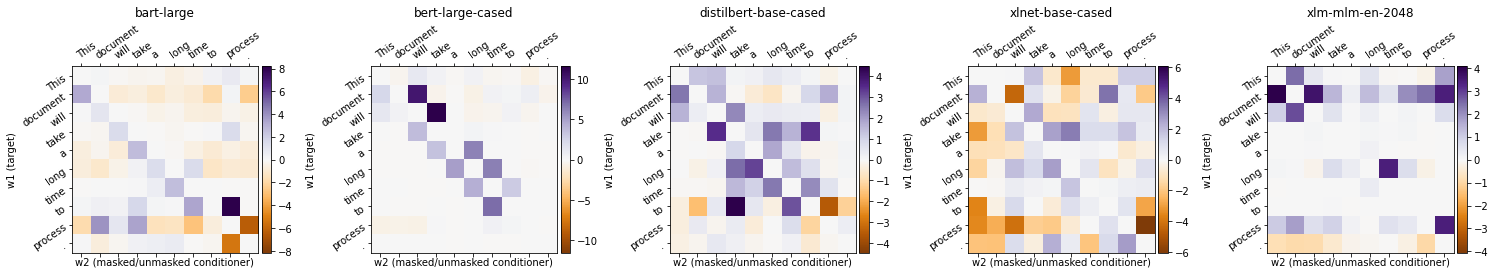

In [21]:
def show_pmi_plot(sent, mat, fig=None, ax=None, title=None):
    lim=max(abs(np.min(mat)),abs(np.max(mat)))
    if ax is None:
        fig, ax = plt.subplots()
    cax = ax.matshow(
        mat, cmap='PuOr',
        norm=colors.TwoSlopeNorm(vcenter=0, vmin=-lim, vmax=lim))
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cax, cax=cax1)
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(sent))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(sent))))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(sent))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(sent))
    ax.tick_params(axis="x", labelrotation=40)
    ax.set_xlabel('w2 (masked/unmasked conditioner)')
    ax.set_ylabel('w1 (target)')
    ax.yaxis.set_label_position("left")
    if title is not None:
        ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=35, ha="left", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=35, ha="right", rotation_mode="anchor")

for s,sent in enumerate(sentences):
    print(*sent)
    # row of plots for sentence s
    figh = 5
    fig, plots = plt.subplots(
        nrows=1, sharex=True, ncols=len(MODELS),
        figsize=(len(MODELS)*figh,figh))
    for m,_ in enumerate(MODELS):
        # plot for sentence s for model m
        pmis_dict=pmis_dicts[m]
        pmis = pmis_dict[str(s)]
        sent, mat = pmis['sentence'], pmis['pmi_matrix']
        show_pmi_plot(
            sent, mat, fig=fig, ax=plots[m], 
            title=MODELS[m].model_spec)
    plt.subplots_adjust(wspace=.5)
    plt.show()

In [16]:
# with np.printoptions(precision=1, suppress=True):
#     for d in pmis_dicts[0].values():
#         print(*d['sentence'])
#         print(d['pmi_matrix'])

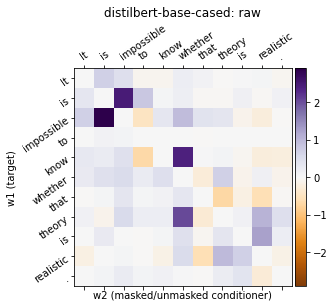

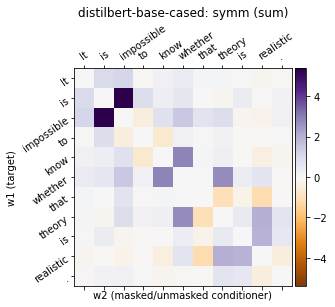

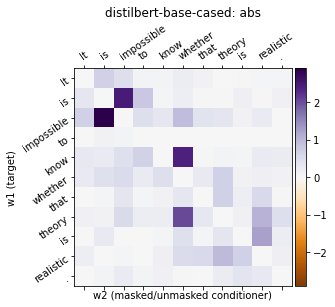

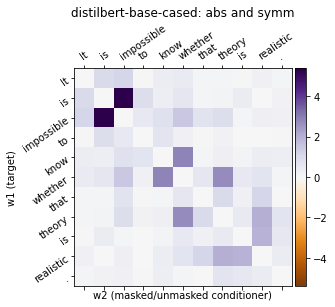

In [42]:
model_number=2
sentence_number=0
p=pmis_dicts[model_number][str(sentence_number)]

show_pmi_plot(p['sentence'], p['pmi_matrix'],
              title=MODELS[model_number].model_spec + ": raw")

show_pmi_plot(p['sentence'], p['pmi_matrix']+p['pmi_matrix'].T,
              title=MODELS[model_number].model_spec + ": symm (sum)")

show_pmi_plot(p['sentence'], abs(p['pmi_matrix']),
              title=MODELS[model_number].model_spec + ": abs")

show_pmi_plot(p['sentence'], abs(p['pmi_matrix'])+abs(p['pmi_matrix']).T,
              title=MODELS[model_number].model_spec + ": abs and symm")